In [1]:
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import pytesseract

In [2]:
# 모호한 참조
def Angle(pt1,pt0,pt2):
    u1 = pt1[0] - pt0[0]
    u2 = pt1[1] - pt0[1]
    v1 = pt2[0] - pt0[0]
    v2 = pt2[1] - pt0[1]
    
    return (u1*v1+u2*v2) / (math.sqrt(u1*u1+u2*u2) * math.sqrt(v1*v1+v2*v2))

# # 사각형 검출 메소드
def Square(src):
    split = cv2.split(src)
    blur = list()

    N = 10
    max = src.shape[0] * src.shape[1] * 0.9
    min = src.shape[0] * src.shape[1] * 0.1
    square = list()

    for channel in range(0,3):
        # 관심 채널의 흐림 효과
        blur = cv2.GaussianBlur(split[channel],(5,5),1)
        for i in range(0,N):
            # 다양한 임곗값의 이진화 이미지
            _ , binary = cv2.threshold(blur,i*255 / N,255,cv2.THRESH_BINARY)
            # 윤곽선 검출
            contours, hierarchy = cv2.findContours(binary,cv2.RETR_LIST,cv2.CHAIN_APPROX_TC89_KCOS)

            # 다각형 근사
            for j in contours:
                perimeter = cv2.arcLength(j, True)
                approx = cv2.approxPolyDP(j, perimeter * 0.02,True)

                area = cv2.contourArea(approx,False)
                convex = cv2.isContourConvex(approx)

                if (len(approx) == 4 and area>min and area < max and convex):
                    approx = np.squeeze(approx) # approx.shape = (4,1,2) -> (4,2)
                    cos = 0.
                    for k in range(1,5):
                        t = abs(Angle(approx[(k-1)%4],approx[k%4],approx[(k+1)%4]))
                        cos = cos if cos > t else t
                    if cos < 0.15: squares = approx
                        
    return squares

def DrawSquare(src, squares):
    return cv2.polylines(src, [squares],True,(0,255,255),3,cv2.LINE_AA,0)

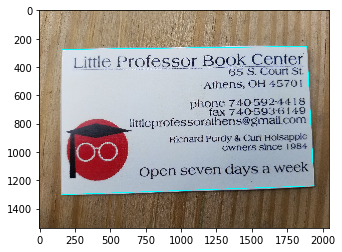

In [3]:
src = cv2.imread('files/business_card3.jpg')
src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)

squares = Square(src)
square = DrawSquare(src, squares)
plt.imshow(square)

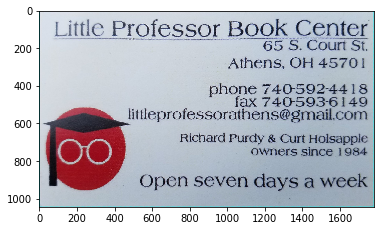

In [4]:
def PerspectiveTransform(src, squares):
    height,width,_ = src.shape
    moments = cv2.moments(squares)
    cX = moments['m10'] / moments['m00']
    cY = moments['m01'] / moments['m00']
    src_pts = np.zeros((4,2),dtype=np.float32)
    for x,y in squares:
        if (cX > x and cY > y): src_pts[0] = [x,y]
        if (cX > x and cY < y): src_pts[1] = [x,y]
        if (cX < x and cY > y): src_pts[2] = [x,y]
        if (cX < x and cY < y): src_pts[3] = [x,y]
            
    max_dstWidth = max(abs(src_pts[0][0] - src_pts[2][0]),abs(src_pts[0][0] - src_pts[3][0]),
                       abs(src_pts[1][0] - src_pts[2][0]),abs(src_pts[1][0] - src_pts[3][0]))
    max_dstHeight = max(abs(src_pts[0][1] - src_pts[1][1]),abs(src_pts[0][1] - src_pts[3][1]),
                       abs(src_pts[2][1] - src_pts[1][1]),abs(src_pts[2][1] - src_pts[3][1]))
        
    dst_pts = np.array([[0,0],[0,max_dstHeight],[max_dstWidth,0],[max_dstWidth,max_dstHeight]],dtype=np.float32)
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    dst = cv2.warpPerspective(src,M,(max_dstWidth,max_dstHeight))
    return dst

dst = PerspectiveTransform(src,squares)
plt.imshow(dst)

In [5]:
outText = pytesseract.image_to_string(dst, lang='kor')
outText

'1106 20165501 ㅁ000 6…ㄴ0 6”\n0905 5.0혀\n\n16105, (01 4570 1\n0110116 74059244 18\n\n18× 7405936 149\n11116101016550123016705@용10311.0070\n\n1이7861[0 24007 & (040 너이58600!6\n0\\116165 50706 1984\n\n \n\n                                                                                                                                                                                                                                                                   \n                                                                                                                                                                                                                                                                    \n \n\n                                                                                                                                                                                                                                                                    \n        

In [6]:
outText = pytesseract.image_to_string(dst, lang='eng')
print(outText)

Little Professor Book Center
65 S. Court St.

Athens, OH 45701
phone 740-592-4418

fax 740-593-6149
litleprofessorathens@gmail.com

Richard Purdy & Curt Holsapple
owners since 1984

 

     
      
 

      
       
   

Open seven days a week
